In [11]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import rasterio
import geopandas as gpd

from shapely.geometry import Polygon

import iceplant_detection_functions as ipf
import model_prep_and_evals as mpe

import warnings

## Create test/train set from samples

In [2]:
samples = pd.read_csv(os.path.join(os.getcwd(),'feature_selection','samples_for_model.csv'))
samples.head(3)

,r,g,b,nir,ndvi,year,month,day_in_year,iceplant,geometry,x,y,aoi,naip_id,polygon_id
0,134,125,103,170,0.118421,2012,5,126,1,POINT (238565.79498225075 3810768.627232482),238565.794982,3.810769e+06,campus_lagoon,ca_m_3411934_sw_11_1_20120505_20120730,0
1,130,114,101,164,0.115646,2012,5,126,1,POINT (238553.15545424985 3810802.7926417096),238553.155454,3.810803e+06,campus_lagoon,ca_m_3411934_sw_11_1_20120505_20120730,0
2,132,110,98,160,0.095890,2012,5,126,1,POINT (238552.77597268307 3810773.0767946127),238552.775973,3.810773e+06,campus_lagoon,ca_m_3411934_sw_11_1_20120505_20120730,0


In [3]:
train, test = mpe.test_train_aois_scenes(samples)

In [14]:
X_train = np.array(np.array(train.loc[:,'r':'day_in_year']))
X_train

array([[43, 51, 78, ..., 2012, 5, 126],
       [65, 59, 84, ..., 2012, 5, 126],
       [81, 86, 93, ..., 2012, 5, 126],
       ...,
       [84, 100, 71, ..., 2020, 5, 142],
       [65, 77, 72, ..., 2020, 5, 142],
       [87, 93, 84, ..., 2020, 5, 142]], dtype=object)

In [15]:
X_test = np.array(np.array(test.loc[:,'r':'day_in_year']))
X_test

array([[124, 104, 99, ..., 2012, 5, 126],
       [135, 119, 99, ..., 2012, 5, 126],
       [96, 98, 100, ..., 2012, 5, 126],
       ...,
       [58, 81, 68, ..., 2020, 5, 142],
       [48, 61, 61, ..., 2020, 5, 142],
       [56, 84, 63, ..., 2020, 5, 142]], dtype=object)

In [16]:
y_train = np.array(train['iceplant'])
y_train

array([0, 0, 0, ..., 1, 0, 0])

In [17]:
y_test = np.array(test['iceplant'])
y_test

array([1, 1, 0, ..., 0, 0, 1])

In [8]:
mpe.iceplant_proportions(y_train)

no-iceplant:iceplant ratio     2.4 :1
          counts  percentage
iceplant                    
0         247696       70.95
1         101425       29.05



In [9]:
mpe.iceplant_proportions(y_test)

no-iceplant:iceplant ratio     2.5 :1
          counts  percentage
iceplant                    
0         106302       71.04
1          43330       28.96



In [ ]:
## 

In [20]:
t0 = time.time()

rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(X_train, y_train)

print('time to train: ', (time.time()-t0))

time to train:  35.77524161338806


In [21]:
predictions = rfc.predict(X_test)
mpe.print_threshold_metrics(y_test, predictions)


true negatives: 104377     false positives: 1925
false negatives: 2295     true positives: 41035

sensitivity (TP/P): 94.7 %
specificity (TN/N): 98.19 %
G-mean:  0.96

precision (TP/(TP+FP)): 95.52 %

MCC:  0.9312979351222674

F1-measure:  0.9511
F0.5-measure (min false positives):  0.95355
F2-measure (min false negatives)  :  0.94865

accuracy: 97.18 %



In [22]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

In [23]:
forest_importances = pd.Series(result.importances_mean, index=['r', 'g', 'b', 'nir', 'ndvi', 'year', 'month', 'day_in_year'])

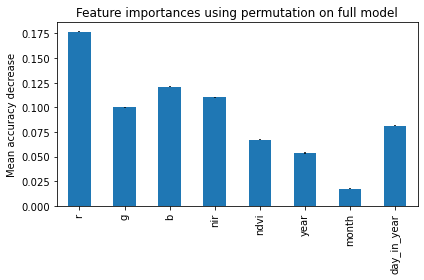

In [24]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Pre-process NAIP scene for prediction

In [ ]:
itemid = 'ca_m_3412037_nw_10_060_20200607'

item = ipf.get_item_from_id(itemid)
scene = ipf.get_raster_from_item(item).read([1,2,3,4])
scene.shape

In [ ]:
ndvi = ipf.ndvi(scene)

# Predict using dask

In [ ]:
import dask
import dask_gateway

cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
#cluster.adapt(minimum=4, maximum=50)
cluster.scale(30)
client